In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,roc_auc_score #scores metrics measures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #matrix confusion
from xgboost import plot_importance
import joblib
import shap

In [2]:
data= pd.read_csv('customer_data.csv')

Starting realizing a EDA

In [3]:
data.head()

,recordID,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,customer_id
0,1,HI,101,510,no,no,0,70.9,123,12.05,...,18.01,236.0,73,10.62,10.6,3,2.86,3,no,23383607.0
1,2,MT,137,510,no,no,0,223.6,86,38.01,...,20.81,94.2,81,4.24,9.5,7,2.57,0,no,22550362.0
2,3,OH,103,408,no,yes,29,294.7,95,50.10,...,20.17,300.3,127,13.51,13.7,6,3.70,1,no,59063354.0
3,4,NM,99,415,no,no,0,216.8,123,36.86,...,10.74,220.6,82,9.93,15.7,2,4.24,1,no,25464504.0
4,5,SC,108,415,no,no,0,197.4,78,33.56,...,10.54,204.5,107,9.20,7.7,4,2.08,2,no,691824.0


In [4]:
data.dtypes

recordID                           int64
state                             object
account_length                     int64
area_code                          int64
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
customer_id                      float64
dtype: object

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12892 entries, 0 to 12891
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   recordID                       12892 non-null  int64  
 1   state                          12892 non-null  object 
 2   account_length                 12892 non-null  int64  
 3   area_code                      12892 non-null  int64  
 4   international_plan             12892 non-null  object 
 5   voice_mail_plan                12892 non-null  object 
 6   number_vmail_messages          12892 non-null  int64  
 7   total_day_minutes              12892 non-null  float64
 8   total_day_calls                12892 non-null  int64  
 9   total_day_charge               12892 non-null  float64
 10  total_eve_minutes              12892 non-null  float64
 11  total_eve_calls                12892 non-null  int64  
 12  total_eve_charge               12892 non-null 

In [6]:
data.describe()

,recordID,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,customer_id
count,12892.00000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,12892.000000,1.289200e+04
mean,6446.50000,100.676621,437.133804,7.996665,180.162023,100.266599,30.628086,200.711852,100.137139,17.060717,200.557834,100.038241,9.025192,10.244702,4.467654,2.766584,1.563683,2.830245e+11
std,3721.74417,39.806413,42.341820,13.641977,54.207056,19.946657,9.215171,50.781851,19.894032,4.316445,50.632872,19.749714,2.278507,2.782623,2.466493,0.751269,1.310606,3.205835e+13
min,1.00000,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.400000e+01
25%,3223.75000,73.000000,408.000000,0.000000,144.000000,87.000000,24.480000,166.200000,87.000000,14.130000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,2.409909e+07
50%,6446.50000,100.000000,415.000000,0.000000,180.000000,101.000000,30.600000,201.150000,100.000000,17.095000,200.800000,100.000000,9.040000,10.300000,4.000000,2.780000,1.000000,3.219535e+07
75%,9669.25000,127.000000,510.000000,19.000000,216.300000,114.000000,36.770000,234.900000,114.000000,19.970000,235.100000,113.000000,10.580000,12.100000,6.000000,3.270000,2.000000,5.535319e+07
max,12892.00000,243.000000,510.000000,52.000000,351.500000,165.000000,59.760000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,3.640000e+15


Checking the balance of the data

In [7]:
data['churn'].value_counts()

churn
no     11069
yes     1823
Name: count, dtype: int64

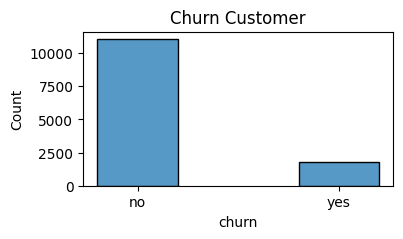

In [8]:
plt.figure(figsize=(4,2)) 
sbn.histplot(data['churn'],shrink=0.4)
plt.title('Churn Customer')
plt.show()

We can see cleary that there are more customer that don't churn so the data is imbalanced

Checking for duplicates

In [9]:
data.duplicated().sum() #there are not duplicates

0

In [10]:
#Checking for missing values
data.isnull().sum() #There are no missing values

recordID                         0
state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
customer_id                      0
dtype: int64

Creating a copy of the data but dropping the columns recordID and customer_id

In [11]:
df= data.drop(['customer_id','recordID'],axis=1)

Checking the diferences of customer who churn and not churn

In [12]:
def showS():
    for i in data.columns:
        print('Column:'+i+'\n')
        print(data.groupby('churn')[i].describe())
        print('\n---------------------------------------------------------------------------------------')

In [13]:
showS()

Column:recordID

         count         mean          std   min     25%     50%     75%  \
churn                                                                    
no     11069.0  6440.229921  3732.705438   1.0  3182.0  6425.0  9658.0   
yes     1823.0  6484.571037  3655.260931  37.0  3440.5  6620.0  9702.5   

           max  
churn           
no     12892.0  
yes    12871.0  

---------------------------------------------------------------------------------------
Column:state

       count unique top freq
churn                       
no     11069     51  WV  356
yes     1823     51  NJ   71

---------------------------------------------------------------------------------------
Column:account_length

         count        mean        std  min   25%    50%    75%    max
churn                                                                
no     11069.0  100.392357  39.906521  1.0  73.0  100.0  127.0  243.0
yes     1823.0  102.402633  39.159588  1.0  76.0  102.0  127.0  225.0

------

Feature Engineering

I will create those new columns to be able to drop all those columns , and like in the function showS() we can see that they're close each other so if I sum and delete those columns
will be more legible and easy to analyse.

In [14]:
df['total_charge']= df['total_day_charge']+df['total_eve_charge']+df['total_night_charge']+df['total_intl_charge'] 

In [15]:
df.groupby('churn')['total_charge'].describe() #The customers that churned has the highest mean of total charge

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
no,11069.0,58.496880,9.396791,23.25,52.24,59.00,65.160,87.48
yes,1823.0,65.453467,13.867510,22.93,53.59,66.91,76.875,96.15


In [16]:
df['total_minutes']= df['total_day_minutes']+df['total_eve_minutes']+df['total_night_minutes']+df['total_intl_minutes']

In [17]:
df.groupby('churn')['total_minutes'].describe()  #The customers that churned has the highest mean of total minutes

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
no,11069.0,584.408284,83.250541,284.3,528.9,589.1,641.3,857.4
yes,1823.0,635.807460,111.298305,319.9,543.6,649.4,725.6,885.0


In [18]:
df['total_calls']= df['total_day_calls']+df['total_eve_calls']+df['total_night_calls']+df['total_intl_calls']

In [19]:
df.groupby('churn')['total_calls'].describe() #They're pretty close esach others in the total of calls

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
no,11069.0,304.782727,34.261872,191.0,282.0,305.0,328.0,416.0
yes,1823.0,305.680197,34.958267,205.0,282.0,306.0,330.0,408.0


Now we drop the columns that we don't need anymore

In [20]:
df= df.drop(['total_day_minutes','total_day_calls',
             'total_day_charge','total_eve_minutes',
             'total_eve_calls','total_eve_charge',
             'total_night_minutes','total_night_calls',
             'total_night_charge','total_intl_minutes',
             'total_intl_calls','total_intl_charge','state'],axis=1)

In [21]:
df.groupby('churn')['number_customer_service_calls'].describe()  #The customers that churned has the highest mean of customer service calls

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
no,11069.0,1.450809,1.164639,0.0,1.0,1.0,2.0,8.0
yes,1823.0,2.249040,1.834679,0.0,1.0,2.0,4.0,9.0


In [22]:
df.groupby('churn')['number_vmail_messages'].describe()   #The customers that churned has the lowest mean of video mail messages

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
no,11069.0,8.493179,13.867111,0.0,0.0,0.0,21.0,52.0
yes,1823.0,4.981898,11.747022,0.0,0.0,0.0,0.0,48.0


Now it's time to encode the variables 

Encoding categorical variables

In [23]:
df['international_plan'] = np.where(df['international_plan'] == 'no',0,1)
df['voice_mail_plan'] = np.where(df['voice_mail_plan'] == 'no',0,1)
df['churn']= np.where(df['churn'] == 'no',0,1)

Checking the relationships between the features

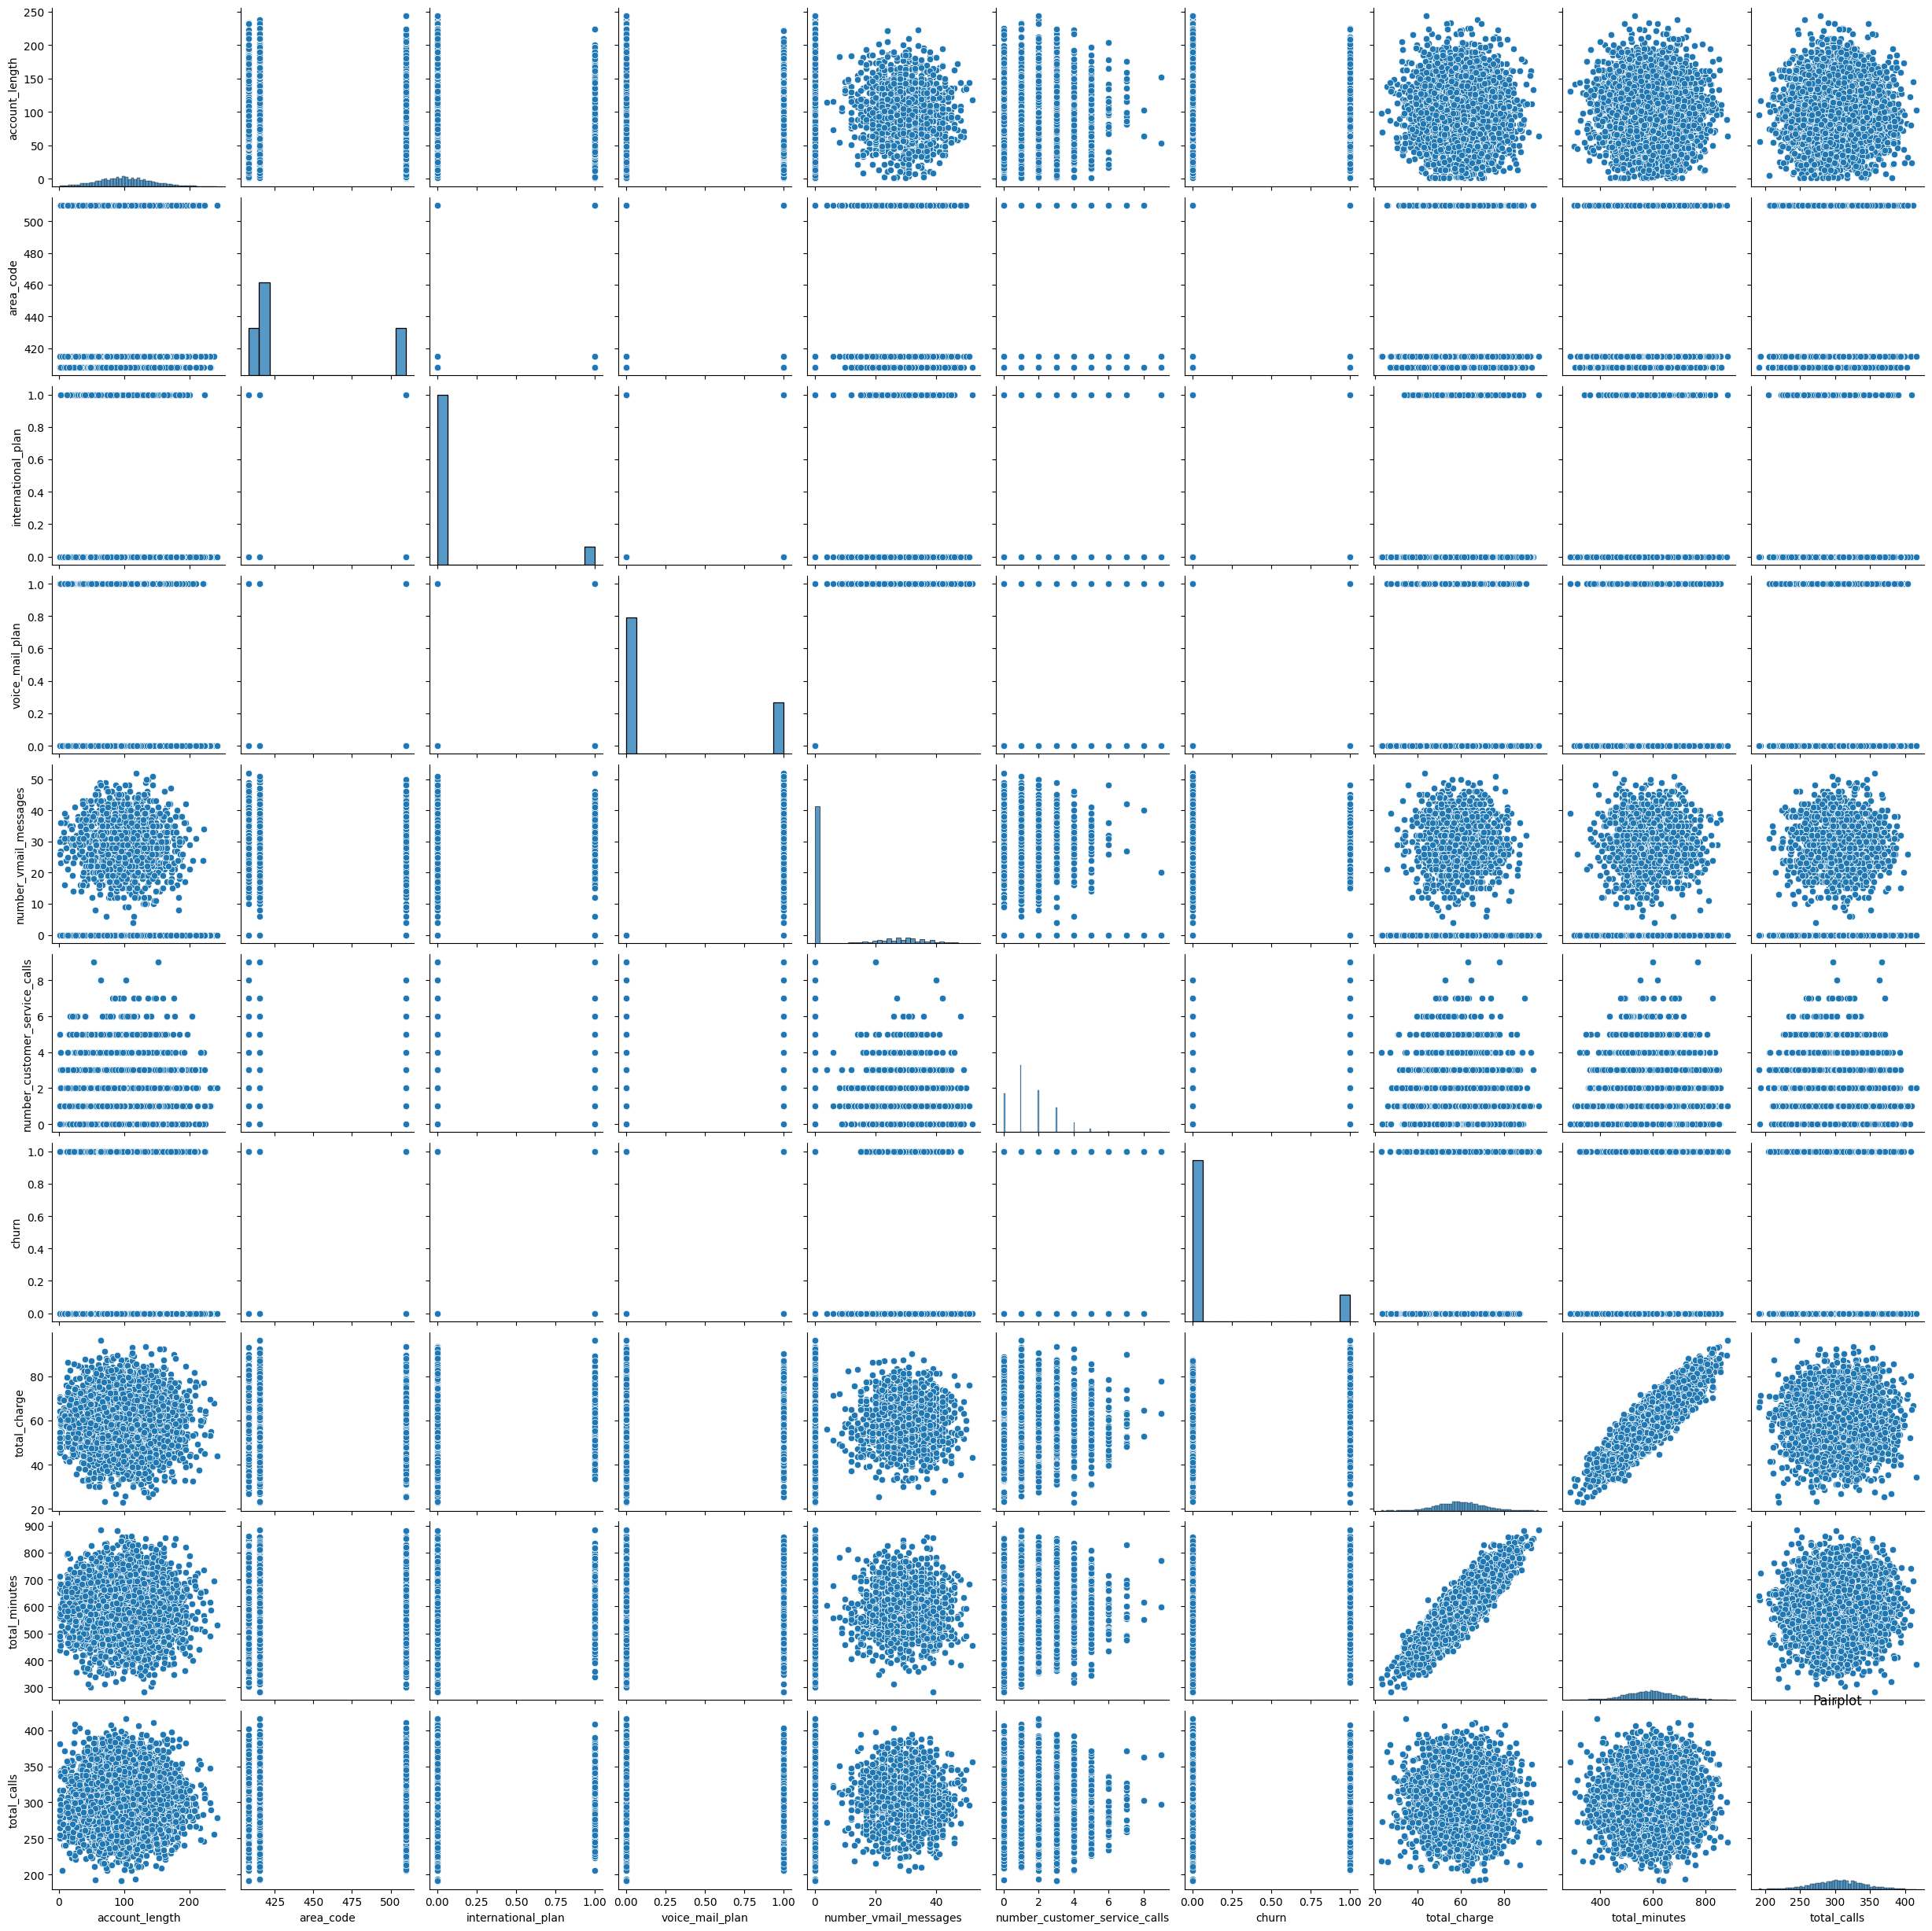

In [24]:
sbn.pairplot(df)
plt.title('Pairplot')
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap')

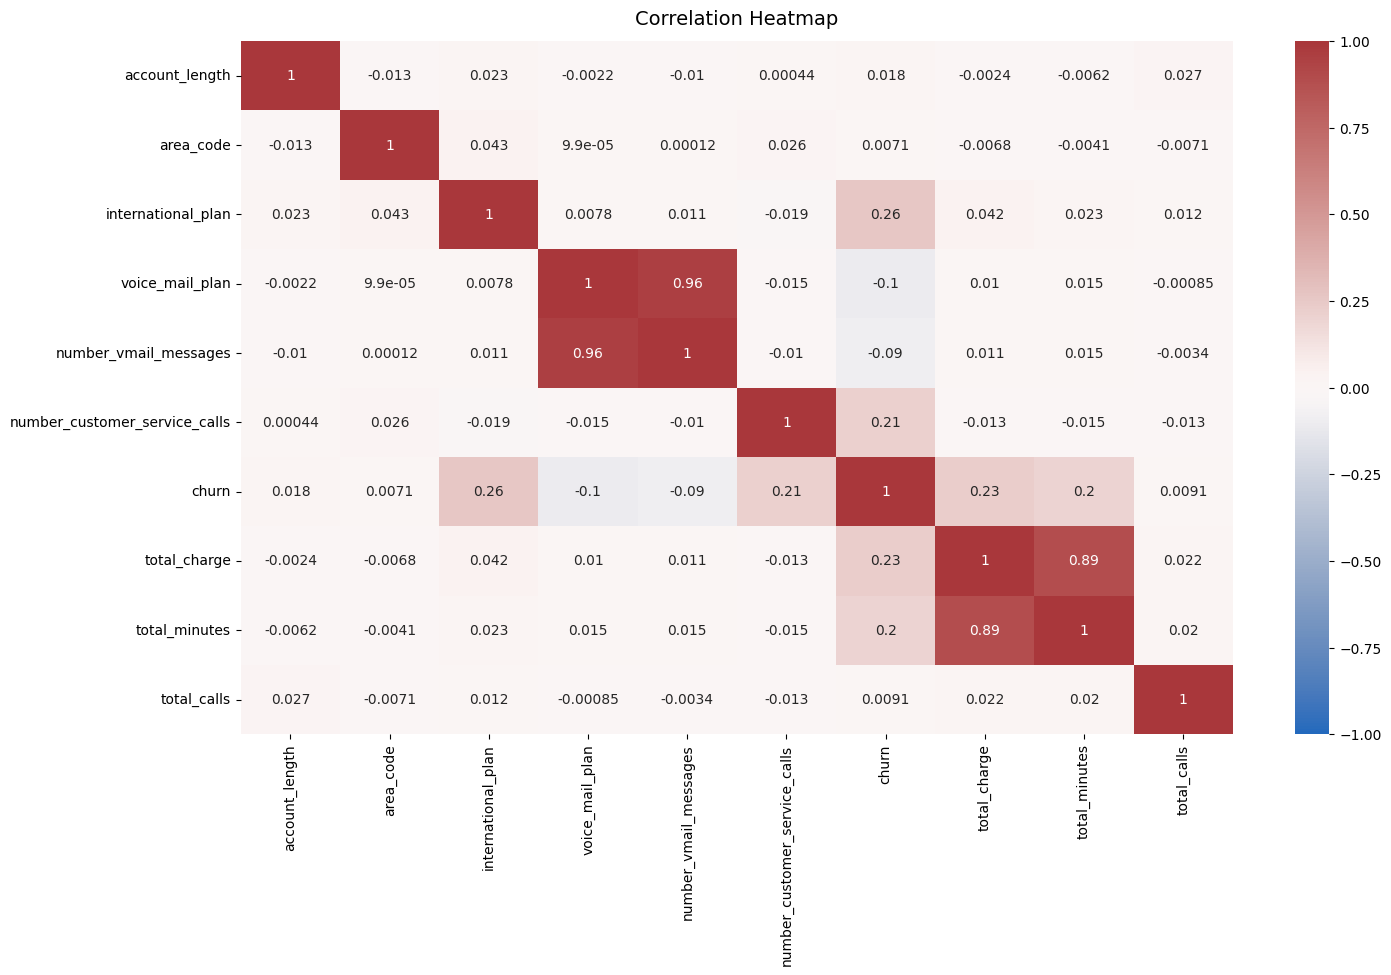

In [25]:
plt.figure(figsize=(16, 9))
heatmap = sbn.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap=sbn.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)

In [26]:
from sklearn.feature_selection import RFE

We separate the targeted variable in y and the predictive features in X, like the decision tree and the random forest are robust against clase imbalance i don have to do anything else

In [27]:
X= df.drop('churn',axis=1)
y= df['churn']

In [28]:
modelTree = DecisionTreeClassifier(random_state=42)

In [29]:
X_tr,X_test,y_tr,y_test = train_test_split(X,y,test_size= 0.2 , random_state= 0) # here we split the data in 80/20 , we've got the 20 of test

In [30]:
X_train,X_validation,y_train,y_validation = train_test_split(X_tr,y_tr,random_state= 0, stratify= y_tr,test_size= 0.2) # here we used the restant data and split it in 60/20

1 Using DecisionTreeClassifier

In [31]:
modelTree.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

We get the predictions 

In [32]:
pred = modelTree.predict(X_validation)

In [33]:
#Function to get the scores
def scoresClassifier(pred,d_test):

         print('Accuracy: {0}%'.format(round(accuracy_score(d_test,pred)*100,2)))

         # Print your precision score.

         ### YOUR CODE HERE ###
         print('Precision: {0}%'.format(round(precision_score(d_test,pred)*100,2)))

         # Print your recall score.
         print('Recall: {0}%'.format(round(recall_score(d_test,pred)*100,2)))

         # Print your f1 score.
         print('F1: {0}%'.format(round(f1_score(d_test,pred)*100,2)))

In [34]:
scoresClassifier(pred,y_validation)

Accuracy: 98.01%
Precision: 91.42%
Recall: 94.86%
F1: 93.11%


In [35]:
#Function to see the confussion matrix
def  confuMatrix_plot(model,x_data_test,y_data_test):
                    
                     pred= model.predict(x_data_test)

                     cm = confusion_matrix(y_data_test, pred)

                     # Create the display for your confusion matrix.

                     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

                     # Plot the visual in-line.                     
                     disp.plot(values_format='')  # `values_format=''` suppresses scientific notation

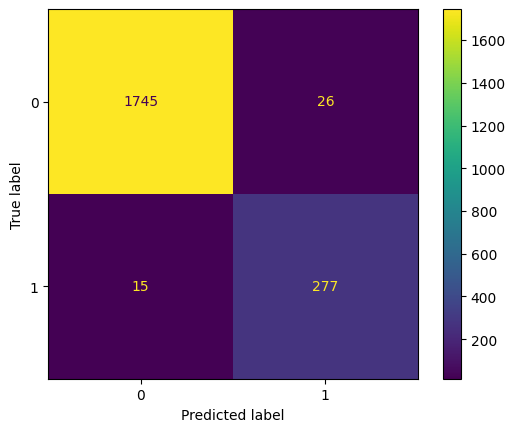

In [36]:
confuMatrix_plot(modelTree,X_validation,y_validation)

In [37]:
def get_test_scores(model_name:str, preds, y_test_data,model):
    '''
    Generate a table of test scores.
    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    aucu= round(roc_auc_score(y_test_data,preds),5)
    accuracy = round(accuracy_score(y_test_data, preds),5)
    precision = round(precision_score(y_test_data, preds),5)
    recall = round(recall_score(y_test_data, preds),5)
    f1 = round(f1_score(y_test_data, preds),5)

    table = pd.DataFrame({'Model': [model_name],
                          'Precision': [precision],
                          'Recall': [recall],
                          'F1': [f1],
                          'Accuracy': [accuracy],
                          'Auc': [aucu]
                        })

    return table

Now we validate the results

In [38]:
results= get_test_scores('DecissionTree',pred,y_validation,modelTree)
results

,Model,Precision,Recall,F1,Accuracy,Auc
0,DecissionTree,0.91419,0.94863,0.93109,0.98013,0.96697


2 Random Forest Classifier

In [39]:
modelRandomForest= RandomForestClassifier(random_state=0)

In [40]:
modelRandomForest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [41]:
results= pd.concat([results,get_test_scores('RandomForestClassifier',modelRandomForest.predict(X_validation),y_validation,modelRandomForest)],axis= 0)

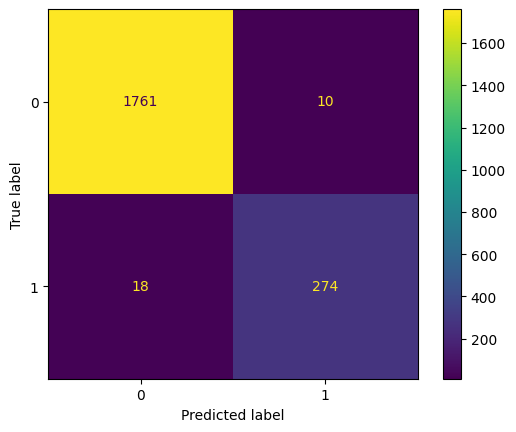

In [42]:
confuMatrix_plot(modelRandomForest,X_validation,y_validation)

3 Models with Cross Validation and Tuning

Decission Tree CV

In [43]:
cv_dt_params = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

In [44]:
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [45]:
DecisionTreeModel_cv= GridSearchCV(modelTree,cv_dt_params,scoring= scoring,cv= 5,refit='f1') #Tunning the model

In [46]:
DecisionTreeModel_cv.fit(X_train,y_train) 

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'min_samples_leaf': [2, 5, 10, 20, 50]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [47]:
pred_df_cv= DecisionTreeModel_cv.best_estimator_.predict(X_validation) #Getting the predictions with the best estimator

In [48]:
results= pd.concat([results,get_test_scores('DecissionTree_CV',pred_df_cv,y_validation,DecisionTreeModel_cv)],axis= 0)

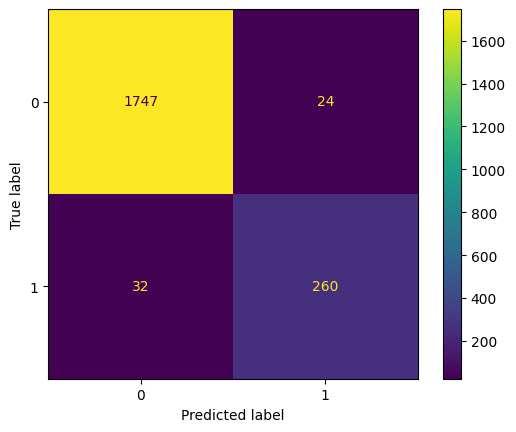

In [49]:
confuMatrix_plot(DecisionTreeModel_cv,X_validation,y_validation)

Random Forest CV

In [50]:
cv_rf_params = {'max_depth': [2,3,4,5, None], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             }  

In [51]:
RandomForest_CV= GridSearchCV(modelRandomForest,cv_rf_params,scoring= scoring, cv= 5, refit= 'f1')

In [52]:
RandomForest_CV.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [75, 100, 125, 150]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [53]:
pred_rf_cv= RandomForest_CV.best_estimator_.predict(X_validation)

In [54]:
results= pd.concat([results,get_test_scores('RandomForestCV',pred_rf_cv,y_validation,RandomForest_CV)],axis=0)

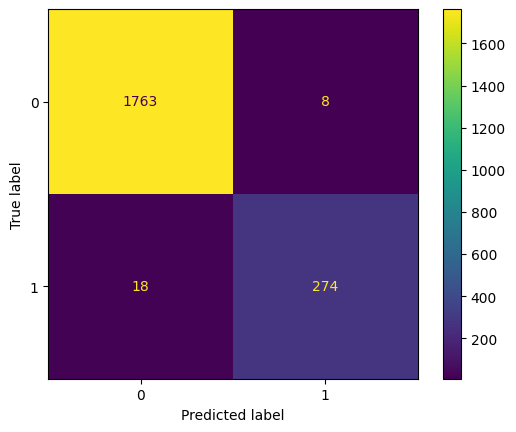

In [55]:
confuMatrix_plot(RandomForest_CV,X_validation,y_validation)
#4 Models with Hyperparameter Tuning using XGBoost

In [56]:
xgb = XGBClassifier(objective= 'binary:logistic',random_state= 0)

In [57]:
cv_xgb_params = {'max_depth': [4,5,6,7,8], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]
             } 

In [58]:
xgb_cv= GridSearchCV(xgb,cv_xgb_params,scoring= scoring, cv= 5, refit='f1')

In [59]:
xgb_cv.fit(X_train,y_train)

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

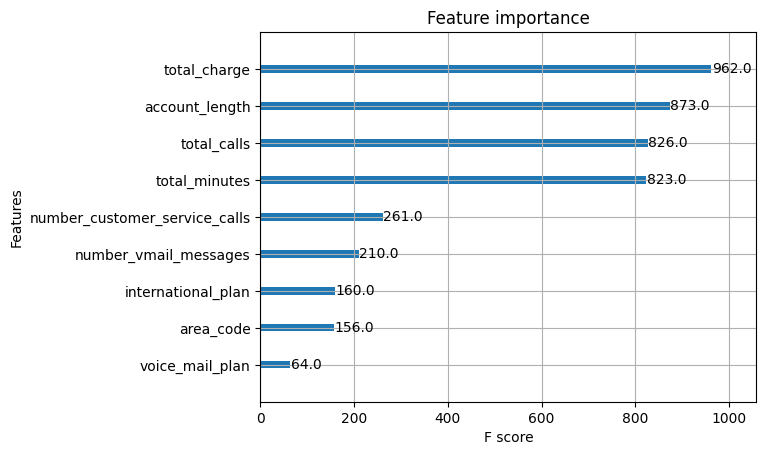

In [60]:
plot_importance(xgb_cv.best_estimator_)

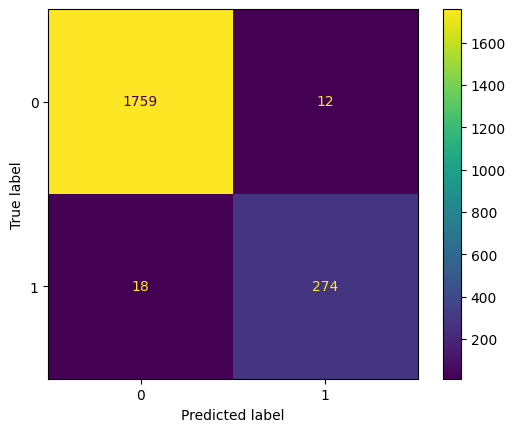

In [61]:
confuMatrix_plot(xgb_cv,X_validation,y_validation)

In [62]:
results= pd.concat([results,get_test_scores('XGB_CV',pred_rf_cv,y_validation,xgb_cv)],axis=0)

Now I'll search with a randomized search 
Define hyperparameter space

As we can see the most efficient models are the Random Forest Cross-validated and the XGBoost Cross-validate 

We'll now go to get the most important features

In [63]:
importance= xgb_cv.best_estimator_.get_booster().get_score(importance_type='gain')
indexImp= list(xgb_cv.best_estimator_.get_booster().get_score(importance_type='gain').keys())[0:9]
valImp= list(xgb_cv.best_estimator_.get_booster().get_score(importance_type='gain').values())[0:9]
importanceDF= pd.DataFrame(data= valImp, index=indexImp, columns=['importance']).sort_values(by='importance',ascending=False)
importanceDF= importanceDF.rename_axis('Features').reset_index()

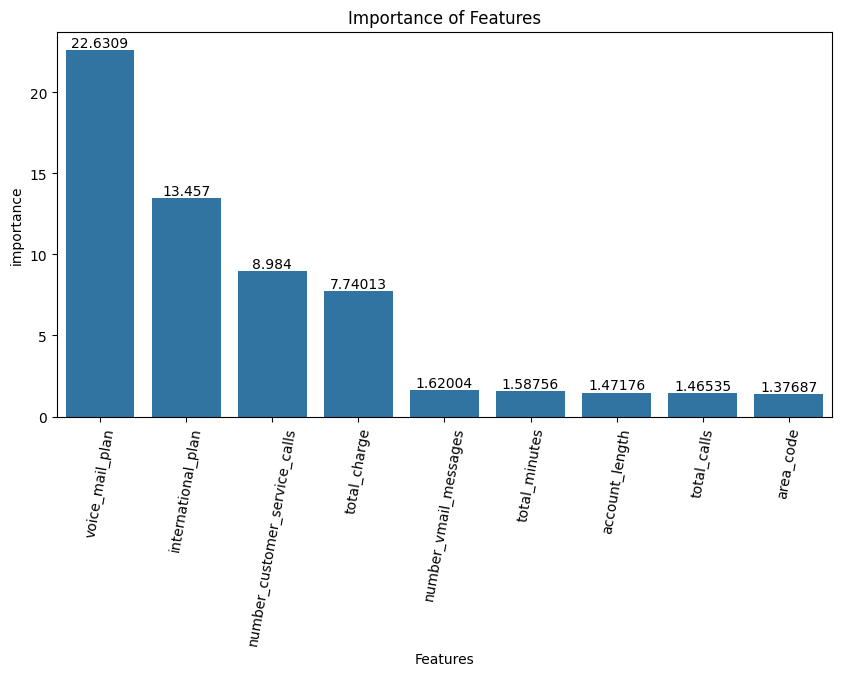

In [64]:
plt.figure(figsize=(10,5))
fig= sbn.barplot(data= importanceDF, x= 'Features', y= 'importance')
plt.xticks(rotation= 80)
plt.bar_label(fig.containers[0])
plt.title('Importance of Features')
plt.show()

models. We can now use these models to make predictions on the test set.

In [65]:
test_result= []

In [66]:
decissionTree_test= get_test_scores('DecissionTree_test',modelTree.predict(X_test),y_test,modelTree)

In [67]:
randomForest_test= get_test_scores('RandomForest_test',modelRandomForest.predict(X_test),y_test,modelRandomForest)

In [68]:
decissionTree_CV_test= get_test_scores('DecissionTree_CV_test',DecisionTreeModel_cv.predict(X_test),y_test,DecisionTreeModel_cv)

In [69]:
randomForest_CV_test= get_test_scores('RandomForest_CV_test',RandomForest_CV.predict(X_test),y_test,RandomForest_CV)

In [70]:
xgb_test= get_test_scores("XGBoost_CV_test",xgb_cv.predict(X_test),y_test,xgb_cv)

In [71]:
test_result= decissionTree_test

In [72]:
test_result= pd.concat([test_result,randomForest_test,decissionTree_CV_test,randomForest_CV_test,xgb_test],axis= 0)

Now we save the models just in case that we have to use it again.

In [73]:
path= './Models/'

In [74]:
joblib.dump(modelTree,path+'modelTree.pkl')

['./Models/modelTree.pkl']

In [75]:
joblib.dump(modelRandomForest,path+'modelRandomForest.pkl')

['./Models/modelRandomForest.pkl']

In [76]:
joblib.dump(DecisionTreeModel_cv,path+'DecissionTree_CV.pkl')

['./Models/DecissionTree_CV.pkl']

In [77]:
joblib.dump(RandomForest_CV,path+'RandomForest_CV.pkl')

['./Models/RandomForest_CV.pkl']

In [78]:
joblib.dump(xgb_cv,path+'XGBoost_CV.pkl')

['./Models/XGBoost_CV.pkl']

In [79]:
'''
In case that you want to load again do this:

loaded_modelTree= joblib.load(path+'modelTree.pkl')

loaded_modelRandomForest= joblib.load(path+'modelRandomForest.pkl')

loaded_DecissionTree_CV= joblib.load(path+'DecissionTree_CV.pkl')

loaded_RandomForest_CV= joblib.load(path+'RandomForest_CV.pkl')

loaded_xgb_cv= joblib.load(path+'XGBoost_CV.pkl')

shap.initjs()

explainer= shap.Explainer(modelRandomForest.predict,X_train)

shap_values= explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test)

'''

"\nIn case that you want to load again do this:\n\nloaded_modelTree= joblib.load(path+'modelTree.pkl')\n\nloaded_modelRandomForest= joblib.load(path+'modelRandomForest.pkl')\n\nloaded_DecissionTree_CV= joblib.load(path+'DecissionTree_CV.pkl')\n\nloaded_RandomForest_CV= joblib.load(path+'RandomForest_CV.pkl')\n\nloaded_xgb_cv= joblib.load(path+'XGBoost_CV.pkl')\n\nshap.initjs()\n\nexplainer= shap.Explainer(modelRandomForest.predict,X_train)\n\nshap_values= explainer.shap_values(X_test)\n\n\nshap.summary_plot(shap_values, X_test)\n\n"

In [80]:
shap.initjs()

In [81]:
explainer_xgb= shap.Explainer(xgb_cv.best_estimator_.predict,X_train)

In [82]:
shap_values_xgb= explainer_xgb(X_test)

ExactExplainer explainer: 2580it [06:52,  6.25it/s]                          


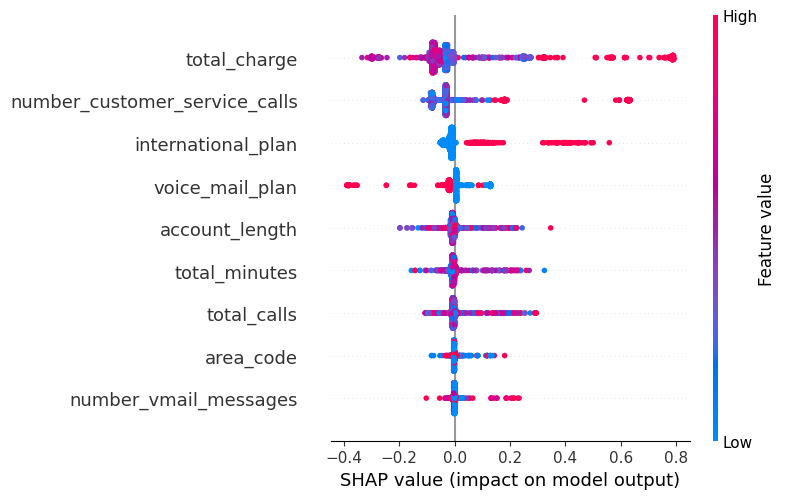

In [83]:
shap.summary_plot(shap_values_xgb, X_test)

In the summary we can see cleary that like in the feature importance the 